In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [6]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [7]:
# 📥 Load and preprocess data
df = pd.read_csv("GlobalWeatherRepository.csv")

In [8]:
# 🔍 Overview of the dataset
print("🔎 Dataset Preview:")
print(df.head())

print("\n📏 Dataset Shape:", df.shape)
print("\n📋 Column Info:")
print(df.info())

print("\n🧮 Missing Values:")
print(df.isnull().sum())

print("\n📊 Basic Statistics:")
print(df.describe())


🔎 Dataset Preview:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    

In [9]:
# 👀 Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
print("\nColumns with Missing Values:\n", missing)


Columns with Missing Values:
 Series([], dtype: int64)


In [10]:
# 🏷️ Define label: travel_safety (0=Unsafe, 1=Caution, 2=Safe)
def assign_travel_safety_label(row):
    if (
        row['visibility_km'] < 2 or
        row['gust_kph'] > 50 or
        row['humidity'] > 90 or
        row['air_quality_PM2.5'] > 75 or
        row['air_quality_us-epa-index'] >= 4
    ):
        return 0
    elif (
        row['visibility_km'] < 5 or
        35 < row['gust_kph'] <= 50 or
        75 < row['humidity'] <= 90 or
        35 < row['air_quality_PM2.5'] <= 75 or
        2 <= row['air_quality_us-epa-index'] < 4
    ):
        return 1
    else:
        return 2

df['travel_safety'] = df.apply(assign_travel_safety_label, axis=1)


In [11]:
# 🧮 Feature selection and train-test split
features = [
    'temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'precip_mm',
    'cloud', 'visibility_km', 'uv_index', 'gust_kph',
    'air_quality_PM2.5', 'air_quality_us-epa-index'
]
X = df[features]
y = df['travel_safety']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# 🔧 PyTorch Dataset
class TravelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TravelDataset(X_train_scaled, y_train)
test_dataset = TravelDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [20]:
# 🔨 PyTorch Neural Network Model
class TravelNet(nn.Module):
    def __init__(self, input_dim):
        super(TravelNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.model(x)

model = TravelNet(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
# 🏋️ Training loop
epochs = 50
train_acc_history = []

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    acc = correct / total
    train_acc_history.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {acc:.4f}")


Epoch 1/50, Accuracy: 0.9917
Epoch 2/50, Accuracy: 0.9926
Epoch 3/50, Accuracy: 0.9919
Epoch 4/50, Accuracy: 0.9913
Epoch 5/50, Accuracy: 0.9920
Epoch 6/50, Accuracy: 0.9927
Epoch 7/50, Accuracy: 0.9923
Epoch 8/50, Accuracy: 0.9922
Epoch 9/50, Accuracy: 0.9924
Epoch 10/50, Accuracy: 0.9924
Epoch 11/50, Accuracy: 0.9935
Epoch 12/50, Accuracy: 0.9928
Epoch 13/50, Accuracy: 0.9935
Epoch 14/50, Accuracy: 0.9928
Epoch 15/50, Accuracy: 0.9925
Epoch 16/50, Accuracy: 0.9930
Epoch 17/50, Accuracy: 0.9926
Epoch 18/50, Accuracy: 0.9937
Epoch 19/50, Accuracy: 0.9931
Epoch 20/50, Accuracy: 0.9929
Epoch 21/50, Accuracy: 0.9933
Epoch 22/50, Accuracy: 0.9935
Epoch 23/50, Accuracy: 0.9939
Epoch 24/50, Accuracy: 0.9932
Epoch 25/50, Accuracy: 0.9929
Epoch 26/50, Accuracy: 0.9933
Epoch 27/50, Accuracy: 0.9934
Epoch 28/50, Accuracy: 0.9939
Epoch 29/50, Accuracy: 0.9933
Epoch 30/50, Accuracy: 0.9932
Epoch 31/50, Accuracy: 0.9933
Epoch 32/50, Accuracy: 0.9932
Epoch 33/50, Accuracy: 0.9944
Epoch 34/50, Accura

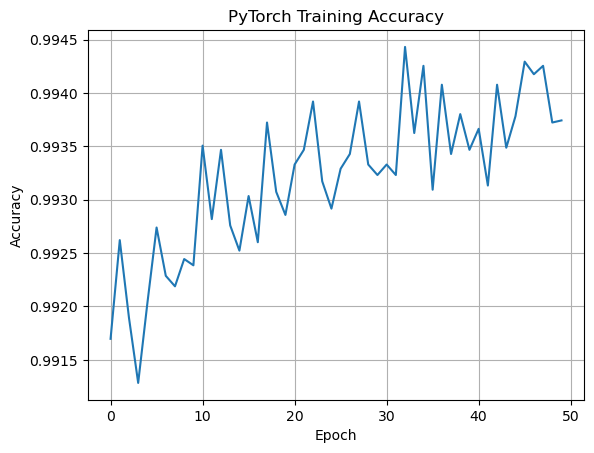

In [26]:
# 📊 Plot training accuracy
plt.plot(train_acc_history)
plt.title("PyTorch Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [28]:
# 📈 Evaluation on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Unsafe", "Caution", "Safe"]))


Classification Report:
              precision    recall  f1-score   support

      Unsafe       0.99      1.00      0.99      2828
     Caution       1.00      1.00      1.00      6503
        Safe       1.00      1.00      1.00      3376

    accuracy                           1.00     12707
   macro avg       1.00      1.00      1.00     12707
weighted avg       1.00      1.00      1.00     12707



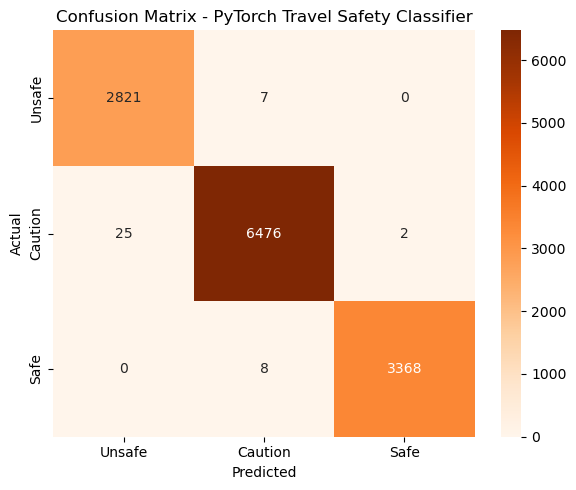

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧮 Correct Confusion Matrix using test labels and predictions
conf_matrix = confusion_matrix(all_labels, all_preds)

# 🔥 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Unsafe", "Caution", "Safe"],
            yticklabels=["Unsafe", "Caution", "Safe"])
plt.title("Confusion Matrix - PyTorch Travel Safety Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

